# **102 Category Flower Dataset**

* **Aashutosh Joshi**
* **Indian Institute of Technology, Kharagpur**

**Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Working with Directories**

In [2]:
train_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/train'
test_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/test'
val_dir = '/kaggle/input/pytorch-challange-flower-dataset/dataset/valid'

**Defining Input Parameters**

In [3]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

**Loading Datasets**

In [4]:
img_height = 224
img_width = 224

# Loading train and and Validation datasets
train_data = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/pytorch-challange-flower-dataset/dataset/train',
  validation_split=None,
  image_size=(img_height, img_width),
  batch_size=128,
  seed=42,
  shuffle=True)

val_data = tf.keras.utils.image_dataset_from_directory(
'/kaggle/input/pytorch-challange-flower-dataset/dataset/valid',
  validation_split=None,
  image_size=(img_height, img_width),
  batch_size=128,
  seed=42)

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.


**Visualization**

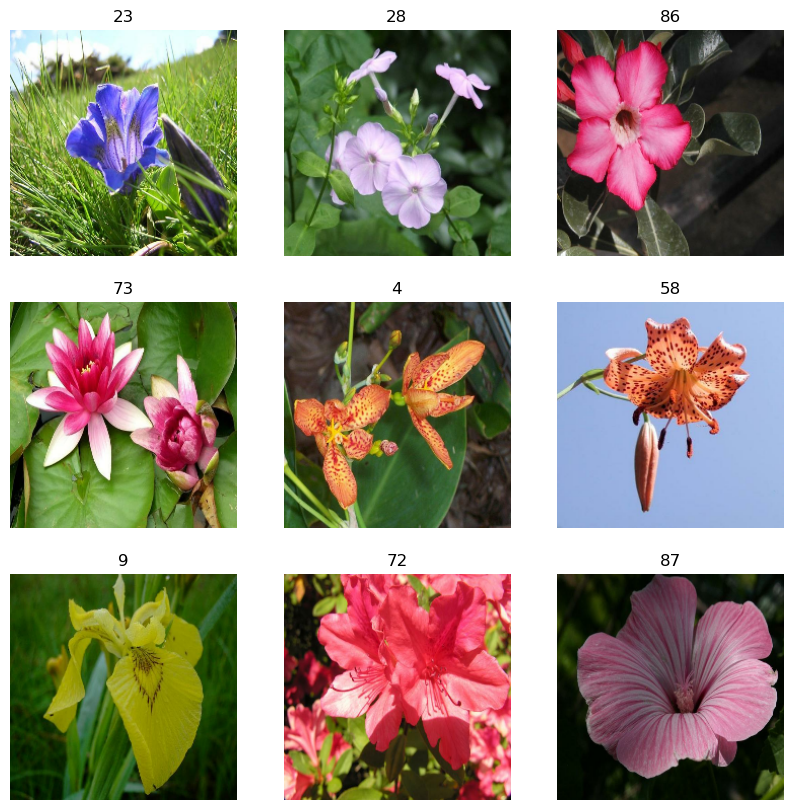

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
# Create the base model from the pre-trained model ResNet 50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


94765736/94765736 [==============================] - 3s 0us/step


In [7]:
IMG_SHAPE

(224, 224, 3)

In [8]:
# Fine-tune last 5 conv layers
for layer in base_model.layers[:-5]:
    layer.trainable=False

**Model Implementation**

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet50 model without the top fully connected layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to prevent them from being trained
base_model.trainable = False

# Add custom layers on top of the ResNet50 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer with 1024 units and ReLU activation
x = Dropout(0.2)(x)  # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units and ReLU activation
x = Dropout(0.2)(x)  # Dropout for regularization

# Output layer for 102 classes (assuming this is a classification problem with 102 classes)
outputs = Dense(102, activation='softmax')(x)

# Create the final model by specifying the input and output
model = Model(inputs=base_model.input, outputs=outputs)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

**Defining Callbacks**

In [10]:
file_path = 'epoch_{epoch:02d}-val_accuracy-{val_sparse_categorical_accuracy:.4f}.hdf5'
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                   monitor = 'val_sparse_categorical_accuracy',
                                                   mode='max',
                                                   verbose=1, 
                                                   save_best_only=True,
                                                   save_weights_only = False)
callbacks_list = [checkpointer,lr] 

**Training the Model**

In [11]:
n_epochs = 20
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']) # accuracy
history = model.fit(train_data, validation_data=val_data, epochs=n_epochs, verbose = 1 ,callbacks= callbacks_list)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 2.3427 - sparse_categorical_accuracy: 0.4548
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.75306, saving model to epoch_01-val_accuracy-0.7531.hdf5
52/52 [==============================] - 39s 504ms/step - loss: 2.3427 - sparse_categorical_accuracy: 0.4548 - val_loss: 0.9134 - val_sparse_categorical_accuracy: 0.7531 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 0.7302 - sparse_categorical_accuracy: 0.7982
Epoch 2: val_sparse_categorical_accuracy improved from 0.75306 to 0.86553, saving model to epoch_02-val_accuracy-0.8655.hdf5
52/52 [==============================] - 24s 439ms/step - loss: 0.7302 - sparse_categorical_accuracy: 0.7982 - val_loss: 0.5166 - val_sparse_categorical_accuracy: 0.8655 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.4183 - sparse_categorical_accuracy: 0.8761
Epoch 3: val_sparse_categorical_accuracy improve

In [12]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'lr'])

**Visualizing Accuracy Curve**

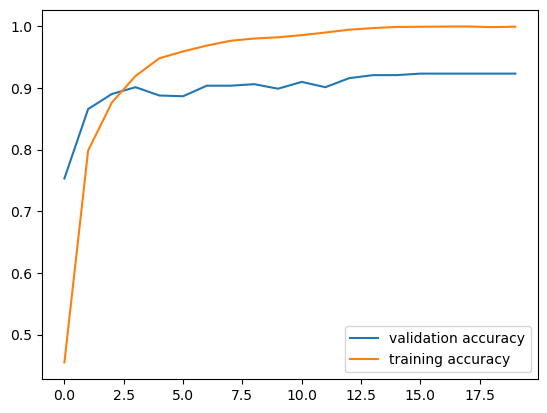

In [13]:
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'validation accuracy')
plt.plot(history.history['sparse_categorical_accuracy'], label = 'training accuracy')
plt.legend()

**Visualizing Loss Curve**

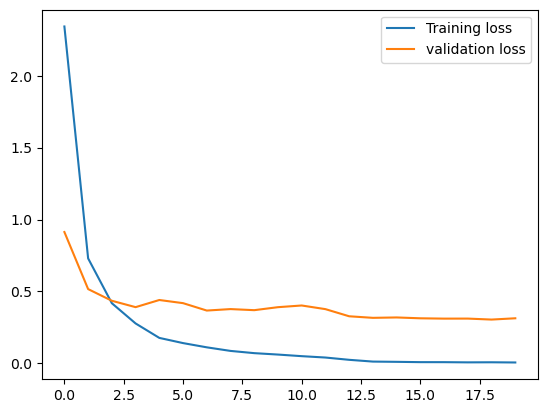

In [14]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.legend()